In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import time

In [37]:
df = pd.read_csv('sample10.csv')  
data = pd.read_csv('sample10.csv') 

categorical_columns = ['income', 'customer_age', 'payment_type', 'employment_status', 'housing_status', 'source', 'device_os', 'device_distinct_emails_8w', 'device_fraud_count', 'month']  

encoder = OneHotEncoder(sparse=False, drop='first')
encoded_df = pd.DataFrame(encoder.fit_transform(df[categorical_columns]))

encoded_df.columns = encoder.get_feature_names_out(categorical_columns)

df = df.drop(columns=categorical_columns) 
df = pd.concat([df, encoded_df], axis=1)  

columns_to_scale = df.columns

scaler = StandardScaler()
scaled_df = df.copy()
scaled_df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [38]:
latent_dim = 100
num_epochs = 20
batch_size = 64

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),  # Daha fazla nöron
            nn.LeakyReLU(0.2),  # LeakyReLU kullanımı
            nn.Linear(256, 512),  # Yeni bir katman
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),  # Daha derin bir model için katman ekleme
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),  # Daha geniş bir katman
            nn.ReLU(),  # ReLU kullanımı
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(input_dim=latent_dim, output_dim=scaled_df.shape[1]).to(device)
discriminator = Discriminator(input_dim=scaled_df.shape[1]).to(device)

# Optimizasyon parametrelerini düzenleme
optimizer_g = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
criterion = nn.BCELoss()

data_tensor = torch.tensor(scaled_df.values, dtype=torch.float32).to(device)
train_loader = DataLoader(TensorDataset(data_tensor), batch_size=batch_size, shuffle=True)

def train_model():
    start_time = time.time()
    for epoch in range(num_epochs):
        for real_data in train_loader:
            real_data = real_data[0]

            batch_size = real_data.size(0)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Discriminator'ı eğit
            optimizer_d.zero_grad()
            outputs = discriminator(real_data)
            d_loss_real = criterion(outputs, real_labels)
            d_loss_real.backward()

            z = torch.randn(batch_size, latent_dim).to(device)
            fake_data = generator(z)
            outputs = discriminator(fake_data.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()
            optimizer_d.step()

            # Generator'ı eğit
            optimizer_g.zero_grad()
            outputs = discriminator(fake_data)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            optimizer_g.step()

        print(f'Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss_real.item() + d_loss_fake.item()} | G Loss: {g_loss.item()}')
    
    end_time = time.time()
    return end_time - start_time

if device.type == 'cuda':
    gpu_time = train_model()
    print(f"GPU eğitim süresi: {gpu_time:.2f} saniye")
else:
    cpu_time = train_model()
    print(f"CPU eğitim süresi: {cpu_time:.2f} saniye")


Epoch [1/20] | D Loss: 1.2155368030071259 | G Loss: 0.7738178372383118
Epoch [2/20] | D Loss: 1.2958661317825317 | G Loss: 0.9359045028686523
Epoch [3/20] | D Loss: 1.344085693359375 | G Loss: 1.2323981523513794
Epoch [4/20] | D Loss: 1.1116885542869568 | G Loss: 1.4677400588989258
Epoch [5/20] | D Loss: 0.8157006502151489 | G Loss: 1.595363736152649
Epoch [6/20] | D Loss: 0.3181740492582321 | G Loss: 2.6887025833129883
Epoch [7/20] | D Loss: 0.1975073739886284 | G Loss: 2.675431489944458
Epoch [8/20] | D Loss: 0.38431842625141144 | G Loss: 3.263629913330078
Epoch [9/20] | D Loss: 0.16476239264011383 | G Loss: 3.450863838195801
Epoch [10/20] | D Loss: 0.15911593846976757 | G Loss: 5.483874797821045
Epoch [11/20] | D Loss: 0.05542097985744476 | G Loss: 4.26059627532959
Epoch [12/20] | D Loss: 0.044217636808753014 | G Loss: 4.54694938659668
Epoch [13/20] | D Loss: 0.24550488591194153 | G Loss: 3.3623297214508057
Epoch [14/20] | D Loss: 0.03608794487081468 | G Loss: 4.633070945739746
Epoc

In [39]:
num_samples = 10000
noise = torch.randn(num_samples, latent_dim)

generated_data = generator(noise).detach().numpy()

generated_df = pd.DataFrame(generated_data, columns=scaled_df.columns)

generated_df[columns_to_scale] = scaler.inverse_transform(generated_df[columns_to_scale])

categorical_output = pd.DataFrame(encoder.inverse_transform(generated_df[encoded_df.columns]))
categorical_output.columns = categorical_columns

generated_df = generated_df.drop(columns=encoded_df.columns)
generated_df = pd.concat([generated_df, categorical_output], axis=1)

In [40]:
generated_df.head()

,name_email_similarity,prev_address_months_count,current_address_months_count,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,...,income,customer_age,payment_type,employment_status,housing_status,source,device_os,device_distinct_emails_8w,device_fraud_count,month
0,0.202342,-27.220644,-1.836954,6.587764,28.113314,2575.304932,8679.772461,6247.457520,5764.664062,-275.822357,...,0.8,30,AD,CB,BC,TELEAPP,x11,1,0,1
1,0.202342,-27.220633,-1.836954,6.587757,28.113314,2575.304932,8679.772461,6247.452637,5764.662598,-275.822296,...,0.8,30,AD,CB,BC,TELEAPP,x11,1,0,3
2,0.202342,-27.220648,-1.836954,6.587764,28.113314,2575.304932,8679.772461,6247.457520,5764.664062,-275.822357,...,0.8,30,AD,CB,BC,TELEAPP,x11,1,0,3
3,0.202342,-27.220648,-1.836954,6.587764,28.113314,2575.304932,8679.772461,6247.457520,5764.664062,-275.822357,...,0.8,30,AD,CB,BC,TELEAPP,x11,1,0,1
4,0.202342,-27.220648,-1.836954,6.587764,28.113314,2575.304932,8679.772461,6247.457520,5764.664062,-275.822357,...,0.8,30,AD,CB,BC,TELEAPP,x11,1,0,1


In [41]:
df_sorted = generated_df.sort_values(by='fraud_bool', ascending=False).reset_index()

df_sorted.loc[:99, 'fraud_bool'] = 1  
df_sorted.loc[100:, 'fraud_bool'] = 0  

generated_df['fraud_bool'] = df_sorted.sort_values(by='index').reset_index(drop=True)['fraud_bool']

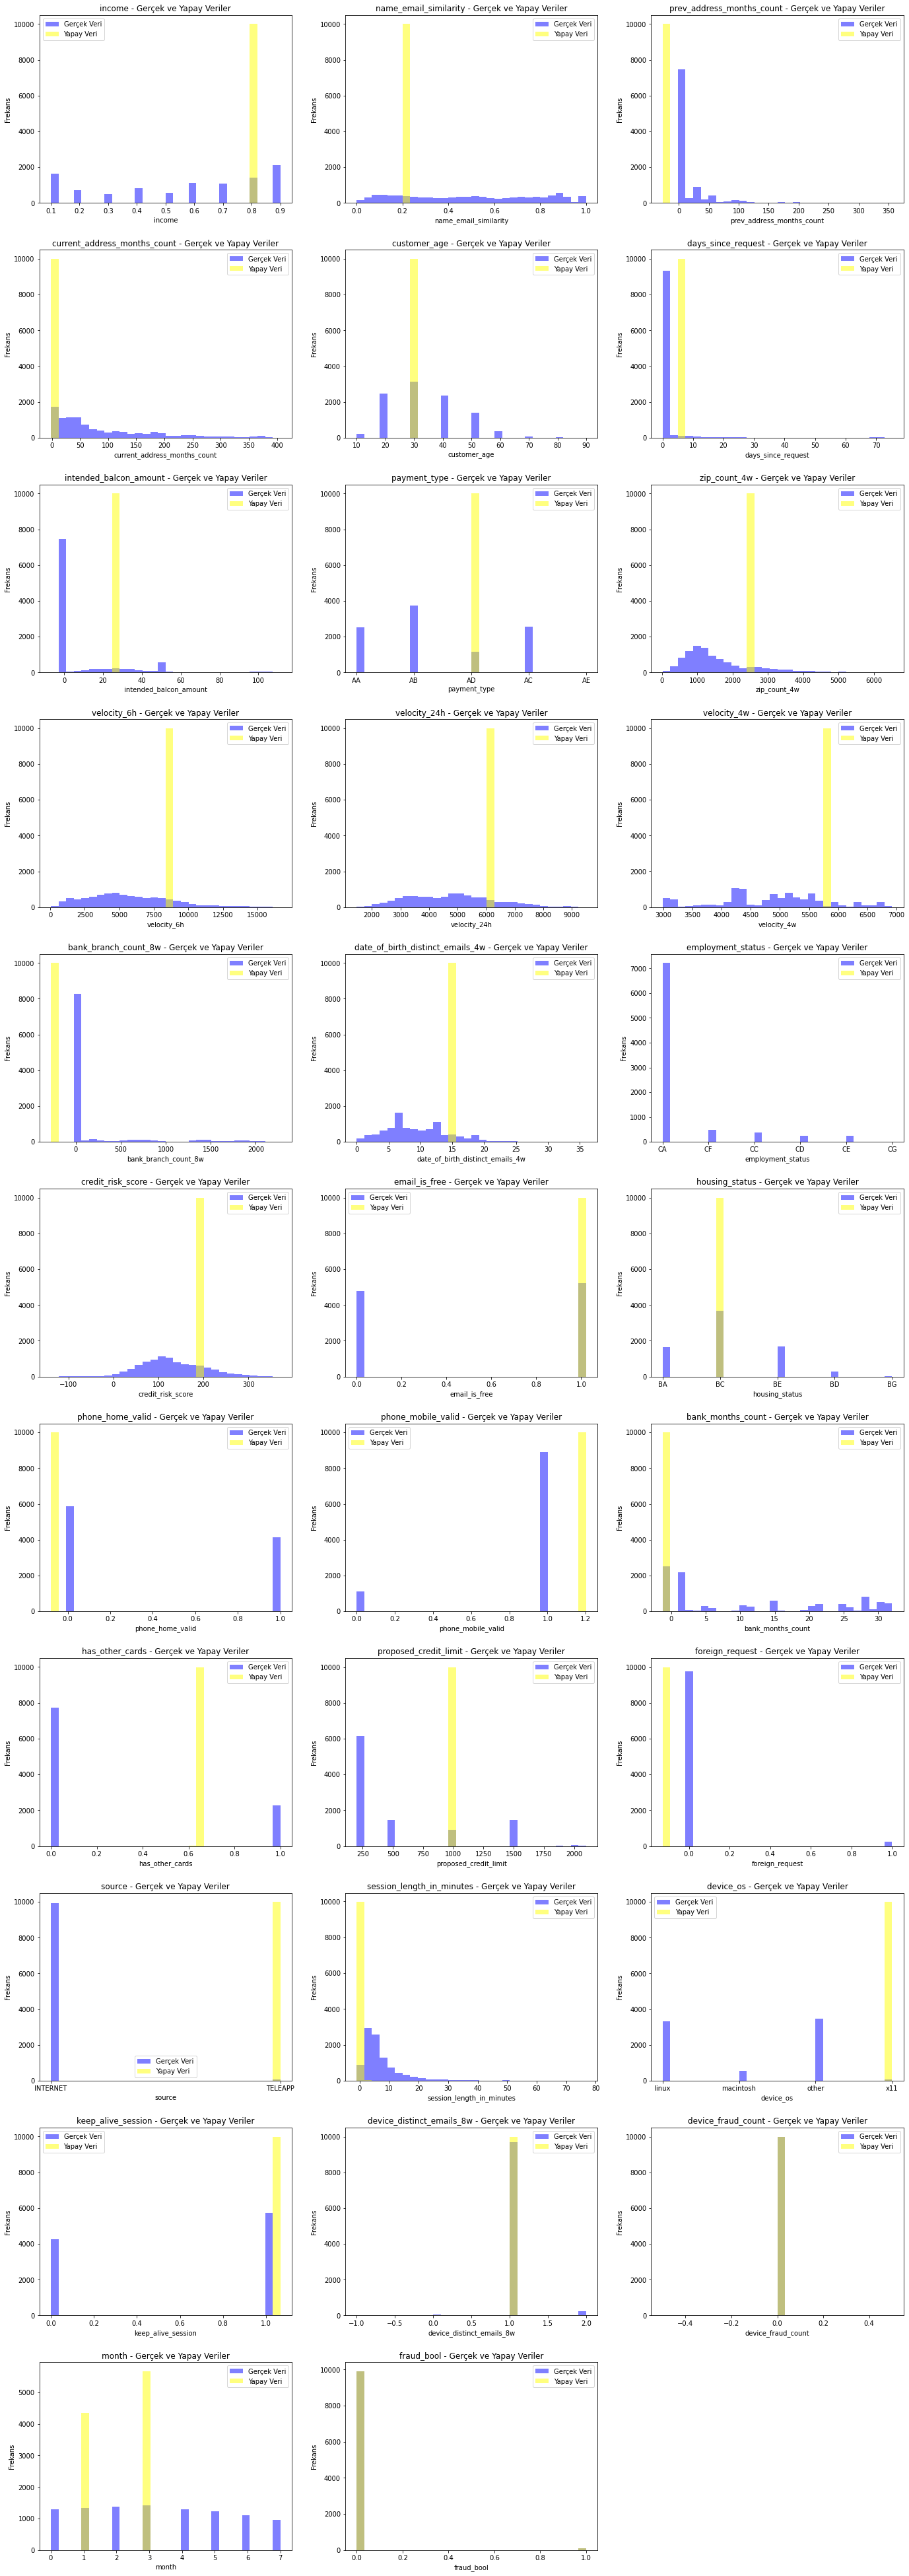

In [42]:
df = data

features = df.columns

num_features = len(features)
num_columns = 3
num_rows = (num_features + num_columns - 1) // num_columns  

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5))
fig.tight_layout(pad=5.0)  

for i, feature in enumerate(features):
    row = i // num_columns
    col = i % num_columns
    
    ax = axes[row, col]
    
    min_val = min(df[feature].min(), generated_df[feature].min())
    max_val = max(df[feature].max(), generated_df[feature].max())
    
    ax.hist(df[feature], bins=30, alpha=0.5, label='Gerçek Veri', color='blue', range=(min_val, max_val))
    ax.hist(generated_df[feature], bins=30, alpha=0.5, label='Yapay Veri', color='yellow', range=(min_val, max_val))
    
    ax.set_title(f'{feature} - Gerçek ve Yapay Veriler')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frekans')
    ax.legend()

for j in range(len(features), num_rows * num_columns):
    fig.delaxes(axes[j // num_columns, j % num_columns])

plt.show()